In [1]:
import jax
#jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import lss_utils
import PT_field

if jax.config.jax_enable_x64:
    print("Using 64-bit precision.")
    base_dtype = jnp.float64
else:
    print("Using 32-bit precision.")
    base_dtype = jnp.float32


Using 32-bit precision.


In [2]:
boxsize = 160.0
kf = 2 * jnp.pi / boxsize
z_ic = 99
z_out = 2.8
OM0 = 0.308

growth = PT_field.growth_D_f(z_out, OM0)[0] / PT_field.growth_D_f(z_ic, OM0)[0]
growth_f = PT_field.growth_D_f(z_out, OM0)[1]
print(growth, growth_f)

### Load the initial conditions and Lyman-alpha field from an appropriate source
root = '/home/akitsukz/works/LyA_field/sherwood'
ics_r = np.load(f'{root}/ics_field_r.npy')
lya_r = np.load(f'{root}/lyA_field_r.npy')
ng = ics_r.shape[0]
print(ng)

ics_k = jnp.fft.rfftn(ics_r, norm='forward') * growth
lya_k = jnp.fft.rfftn(lya_r, norm='forward')

ics_k = ics_k.at[0,0,0].set(0.0)
lya_k = lya_k.at[0,0,0].set(0.0)

26.1238 0.9783371
128


In [3]:
k_edges = jnp.linspace(kf, 2.5, 50)

mu_min = 0.
mu_max = 1.0

measure_pk = lss_utils.Measure_Pk(boxsize, ng, k_edges, dtype=base_dtype)
pk_ic = measure_pk(ics_k, mu_min=mu_min, mu_max=mu_max)
pk_lya = measure_pk(lya_k, mu_min=mu_min, mu_max=mu_max)
pk_cross = measure_pk(ics_k, lya_k, mu_min=mu_min, mu_max=mu_max)

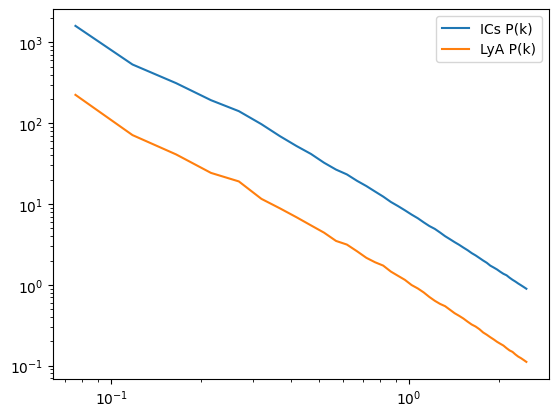

In [4]:
plt.plot(pk_ic[:,0], pk_ic[:,1], label='ICs P(k)')
plt.plot(pk_lya[:,0], pk_lya[:,1], label='LyA P(k)')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [5]:
ng_L = int(1.5*ng)
ng_E = ng
window_order = 2
interlace = True

model = PT_field.LPT_Forward(boxsize=boxsize, ng_L=ng_L, ng_E=ng_E, 
                             mas_cfg=(window_order, interlace), 
                             rsd=True, lya=True, lpt_order=1,
                             dtype=base_dtype,
                             )

shifted_fields = model.get_shifted_fields(ics_k, growth_f=growth_f)
shifted_1, shifted_d, shifted_d2, shifted_G2, shifted_G2_zz, shifted_deta, shifted_eta2, shifted_KK_zz = shifted_fields

idx_to_fields = {0:'1', 1:'d', 2:'d2', 3:'G2', 4:'G2_zz', 5:'deta', 6:'eta2', 7:'KK_zz'}


In [6]:
mu_edges = jnp.array([0.0, 0.25, 0.5, 0.75, 1.0])

idx_to_mu = {0: r'$\mu\in [0, 0.25]$', 
             1: r'$\mu\in [0.25, 0.5]$',
             2: r'$\mu\in [0.5, 0.75]$',
             3: r'$\mu\in [0.75, 1]$',
             }

measure_pk_E = lss_utils.Measure_Pk(boxsize, ng_E, k_edges, dtype=base_dtype)

k_arr, pks_auto, Nmodes = PT_field.compute_pks_2d(shifted_fields, mu_edges, measure_pk=measure_pk_E)

#pks_auto: (n_fields, Nk, Nmu)

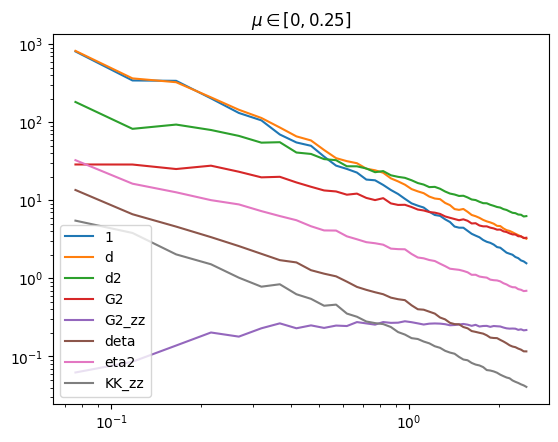

In [7]:
i_field = 0
i_mu = 0
mu = idx_to_mu[i_mu]
for i_field in range(len(shifted_fields)):
    field = idx_to_fields[i_field]
    plt.plot(k_arr, pks_auto[i_field,:,i_mu], label=f'{field}')

plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [8]:
orthogonalized_fields = PT_field.orthogonalize(
    jnp.array([shifted_d, shifted_1 - 3./7.*growth_f*shifted_G2_zz, 
               shifted_d2, shifted_G2,
               shifted_deta, shifted_eta2, shifted_KK_zz]), 
               boxsize=boxsize,
               k_edges=k_edges, mu_edges=mu_edges,
               measure_pk=measure_pk_E,
               jitter=0.0,
               dtype=base_dtype,
               )

idx_to_ortho_fields = {0:'d', 1:'1', 2:'d2', 3:'G2', 4:'deta', 5:'eta2', 6:'KK_zz'}

### check orthogonalization

In [9]:
k_arr, rij = PT_field.compute_corr_2d(orthogonalized_fields, mu_edges, measure_pk=measure_pk_E)
PT_field.check_max_rij(rij)

0
01  max|r_ij| = 1.064e-06
02  max|r_ij| = 2.134e-06
03  max|r_ij| = 9.941e-06
04  max|r_ij| = 2.420e-06
05  max|r_ij| = 5.267e-06
06  max|r_ij| = 4.105e-06
12  max|r_ij| = 1.374e-05
13  max|r_ij| = 1.954e-04
14  max|r_ij| = 2.372e-05
15  max|r_ij| = 6.649e-06
16  max|r_ij| = 4.003e-05
23  max|r_ij| = 2.722e-04
24  max|r_ij| = 3.297e-05
25  max|r_ij| = 7.737e-06
26  max|r_ij| = 6.173e-05
34  max|r_ij| = 4.761e-04
35  max|r_ij| = 5.280e-05
36  max|r_ij| = 8.012e-04
45  max|r_ij| = 8.633e-06
46  max|r_ij| = 1.021e-04
56  max|r_ij| = 1.008e-05
1
01  max|r_ij| = 1.640e-06
02  max|r_ij| = 2.277e-06
03  max|r_ij| = 6.495e-05
04  max|r_ij| = 4.608e-05
05  max|r_ij| = 6.525e-06
06  max|r_ij| = 4.201e-05
12  max|r_ij| = 4.830e-05
13  max|r_ij| = 7.938e-04
14  max|r_ij| = 4.145e-04
15  max|r_ij| = 6.298e-05
16  max|r_ij| = 4.754e-04
23  max|r_ij| = 4.075e-04
24  max|r_ij| = 2.157e-04
25  max|r_ij| = 3.221e-05
26  max|r_ij| = 2.443e-04
34  max|r_ij| = 4.716e-03
35  max|r_ij| = 7.174e-04
36  max|

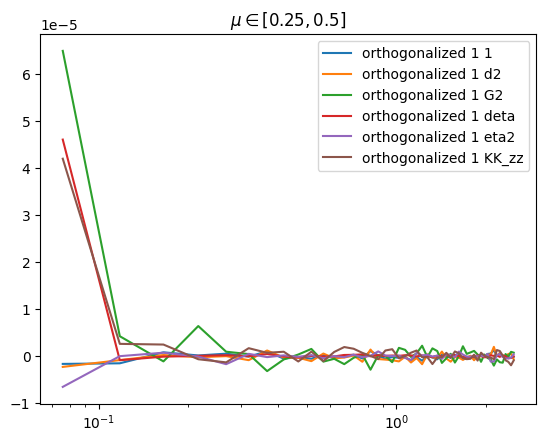

In [10]:
i_mu = 1
i_field = 0

mu = idx_to_mu[i_mu]
field_i = idx_to_fields[i_field]
for j_field in range(i_field+1, len(orthogonalized_fields)):
    field_j = idx_to_ortho_fields[j_field]
    plt.plot(k_arr, 
             rij[i_mu, i_field, j_field,:],
             label=f'orthogonalized {field_i} {field_j}')

plt.title(mu)
plt.legend()
plt.xscale('log')
#plt.yscale('log')

### Plot auto-power spectra of the orthogonalized fields

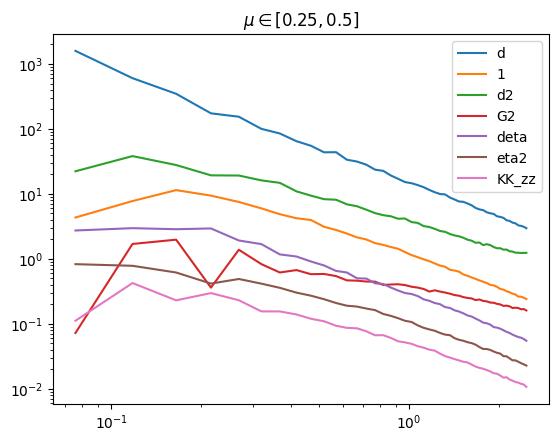

In [11]:
i_mu = 1
mu = idx_to_mu[i_mu]

k_arr, pks_auto_ortho, Nmodes = PT_field.compute_pks_2d(orthogonalized_fields, mu_edges, measure_pk=measure_pk_E)

for i_field in range(len(orthogonalized_fields)):
    field = idx_to_ortho_fields[i_field]
    plt.plot(k_arr, pks_auto_ortho[i_field,:,i_mu], label=f'{field}')

plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')

### compute $\beta_i(k, \mu)$ and get the final PT fields

In [12]:
beta_tab = model.get_beta(lya_k, orthogonalized_fields, 
                          mu_edges, measure_pk=measure_pk_E)

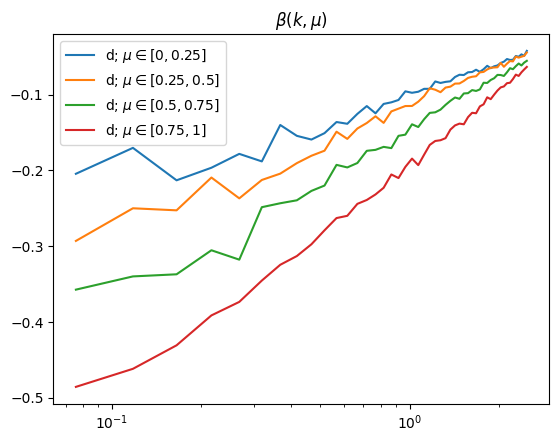

In [13]:
i_field = 0
field = idx_to_ortho_fields[i_field]

for i_mu in range(len(mu_edges)-1):
    mu = idx_to_mu[i_mu]
    plt.plot(k_arr, beta_tab[i_field,:,i_mu], 
             label=f'{field}; {mu}')

plt.title(r'$\beta(k,\mu)$')
plt.legend()
plt.xscale('log')

In [14]:
delta_g_k_linear = model.get_final_field(orthogonalized_fields[0,None],
                                         beta_tab[0,None],
                                         k_edges=k_edges, mu_edges=mu_edges,)

delta_g_k_cubic = model.get_final_field(orthogonalized_fields,
                                        beta_tab,
                                        k_edges=k_edges, mu_edges=mu_edges,)

fields = jnp.stack([lya_k, 
                    delta_g_k_linear, 
                    delta_g_k_cubic,
                    lya_k - delta_g_k_linear,
                    lya_k - delta_g_k_cubic
                    ], 
                   axis=0)

idx_to_PT_fields = {0:'LyA', 1:'linear', 2:'cubic', 3:'err; linear', 4:'err; cubic'}

k_arr, pks_auto_PT, Nmodes = PT_field.compute_pks_2d(fields, mu_edges, measure_pk=measure_pk_E)


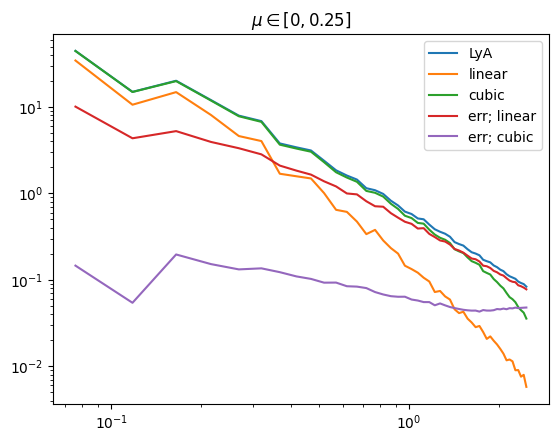

In [23]:
i_mu = 0
mu = idx_to_mu[i_mu]

for i_field in range(len(fields)):
    field = idx_to_PT_fields[i_field]
    plt.plot(k_arr, pks_auto_PT[i_field,:,i_mu], label=f'{field}')

plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')

### Get test polynomial coefficients

In [16]:
poly_k_pows  = jnp.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
poly_mu_pows = jnp.array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2])
pairwise = True
# This corresponds to 
# k^0, k^1, k^2, k^3, k^4, mu^2, k^1 mu^2, k^2 mu^2, k^3 mu^2, k^4 mu^2
#

#This is equivalent to:
#poly_k_pows  = jnp.array([0, 1, 2, 3, 4,])
#poly_mu_pows = jnp.array([0, 2,])
#pairwise = False
#This generates the all combinations of k and mu powers.

coeffs, beta_fit = PT_field.beta_polyfit(
    beta_tab,
    measure_pk=measure_pk_E,
    mu_edges=mu_edges,
    poly_k_pows=poly_k_pows,
    poly_mu_pows=poly_mu_pows,
    pairwise=pairwise,
    ridge=0.0,
    dtype=jnp.float32,
)


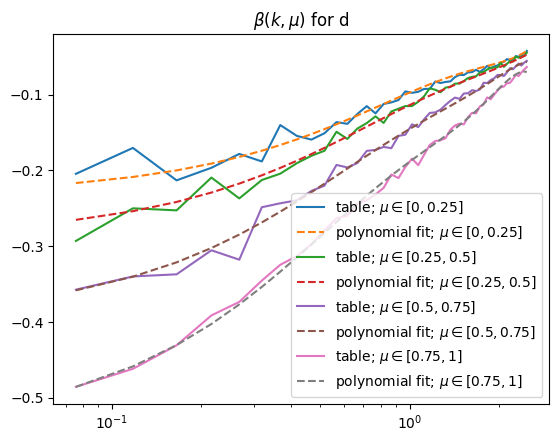

In [17]:
i_field = 0
field = idx_to_ortho_fields[i_field]

for i_mu in range(len(mu_edges)-1):
    mu = idx_to_mu[i_mu]
    plt.plot(k_arr, beta_tab[i_field,:,i_mu], 
             label=f'table; {mu}')
    plt.plot(k_arr, beta_fit[i_field,:,i_mu],
             label=f'polynomial fit; {mu}',
             linestyle='dashed')

plt.title(r'$\beta(k,\mu)$ for' +  f' {field}')
plt.legend()
plt.xscale('log')

### Generate the field given a polynomial $\beta(k,\mu) = \sum_{a,b} c^i_{a,b} k^{p_a} \mu^{2q_b}$

In [18]:
delta_g_k = model.get_final_field(orthogonalized_fields,
                                  coeffs,
                                  beta_type='poly',
                                  poly_k_pows=poly_k_pows,
                                  poly_mu_pows=poly_mu_pows,
)

fields_poly = jnp.stack([
                         delta_g_k,
                         lya_k - delta_g_k,
                         ], 
                         axis=0)

idx_to_PT_poly_fields = {0:'cubic; poly fit', 1:'err; cubic; poly fit'}

k_arr, pks_auto_PT_poly, Nmodes = PT_field.compute_pks_2d(fields_poly, mu_edges, measure_pk=measure_pk_E)

    

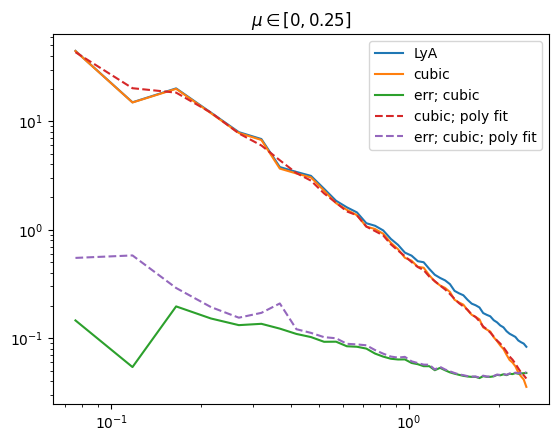

In [19]:
i_mu = 0
mu = idx_to_mu[i_mu]

for i_field in [0, 2, 4]:
    field = idx_to_PT_fields[i_field]
    plt.plot(k_arr, pks_auto_PT[i_field,:,i_mu], label=f'{field}')

for i_field in range(len(fields_poly)):
    field = idx_to_PT_poly_fields[i_field]
    plt.plot(k_arr, 
             pks_auto_PT_poly[i_field,:,i_mu], 
             linestyle='dashed',
             label=f'{field}')

plt.title(mu)
plt.legend()
plt.xscale('log')
plt.yscale('log')